In [ ]:
!pip install --upgrade cmdstanpy
!pip install git+https://github.com/OriolAbril/arviz.git@ci

from cmdstanpy import install_cmdstan
install_cmdstan()

  Running command git checkout -b ci --track origin/ci
  Switched to a new branch 'ci'
  Branch 'ci' set up to track remote branch 'ci' from 'origin'.
  Resolved https://github.com/OriolAbril/arviz.git to commit 7c20182c25b0b5e9af8242d1ee4d1185ae82b70a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.33.1
Download successful, file: /tmp/tmpjnao93p_
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.33.1
Building version cmdstan-2.33.1, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.33.1
Test model compilation


True

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Create ./stan folder if does not exists
if not os.path.exists("./stan"):
    os.mkdir("./stan")

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
!pip install mycolorpy

  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3853 sha256=edc0b8666b7d33ef235a281048a34d86f9bdbe78cb0a9e935b9521a2a573b690
  Stored in directory: /root/.cache/pip/wheels/d6/1d/04/f8bfb8b04e3daba330b3f377c041b89304271ff98fb6704946
Successfully built mycolorpy


# **Data** **Generation**

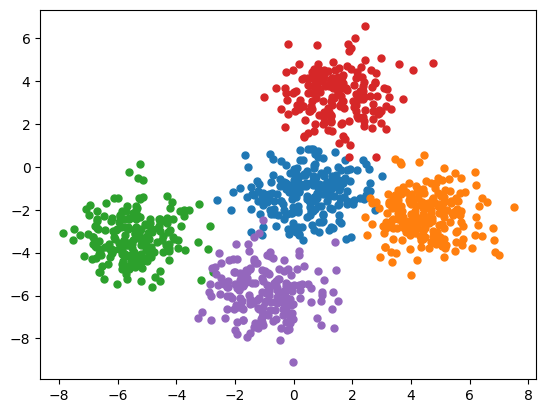

In [ ]:
from IPython.utils.sysinfo import num_cpus

# numero di cluster
K = 5

# dimensione del campione
d = 2

# numero di sample
N = 1000

seed = 2001
key = random.PRNGKey(seed)
# vectors of mean of clusters
sigma = 3
mu = random.normal(key,(K,d))*sigma

# cluster assignment
key = random.PRNGKey(2)
c = random.categorical(key,(1/K)*jnp.ones(shape=(K,)),axis=0,shape=(N,))
C = np.zeros(shape=(N,K))
for i in range(N):
  C[i,c[i]] = 1
C = jnp.array(C)

# Data
X = jnp.matmul(C,mu) + random.normal(key,(N,d))
import matplotlib.pyplot as plt

for i in range(K):
  plt.scatter(X[c==i,0], X[c==i,1], s = 25)
plt.show()

Implementation of MCMC in STAN(based on hamiltonian MC)

In [ ]:
gaussian_mix_uni = """
data {
  int N;
  int K;
  int d;
  matrix[N, d] y;
  vector[d] mu0;
  real <lower=0> sigma0;
  real <lower=0> sigmamax;
}

parameters {
  matrix[K,d] means;
  vector<lower=0>[K] std_devs;
  simplex[K] weights;

}

transformed parameters {
}

model {

   //Likelihood
   vector[K] contributions;
   for (i in 1:N){
     for (k in 1:K){
      contributions[k] = log(weights[k]) + multi_normal_lpdf(y[i] | means[k], diag_matrix(rep_vector(std_devs[k],d)));
      }
      target += log_sum_exp(contributions);
    }


   // Prior
   for(k in 1:K){
    means[k] ~ multi_normal(mu0, sigma0 * diag_matrix(rep_vector(std_devs[k],d)));
   }
   for(k in 1:K){
    std_devs[k] ~ cauchy(0.0,sigmamax);
   }
   weights ~ dirichlet(rep_vector(1,K));


}

generated quantities{
}
"""

# Write stan model to file
stan_file = "./stan/gaussian_mix_uni.stan"
with open(stan_file, "w") as f:
    print(gaussian_mix_uni, file=f)

# Compile stan model
gaussian_mix_uni = CmdStanModel(stan_file=stan_file)

10:15:27 - cmdstanpy - INFO - compiling stan file /content/stan/gaussian_mix_uni.stan to exe file /content/stan/gaussian_mix_uni
INFO:cmdstanpy:compiling stan file /content/stan/gaussian_mix_uni.stan to exe file /content/stan/gaussian_mix_uni
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=gaussian_mix_uni.stan /content/stan/gaussian_mix_uni
cwd: /root/.cmdstan/cmdstan-2.33.1
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=gaussian_mix_uni.stan --o=/content/stan/gaussian_mix_uni.hpp /content/stan/gaussian_mix_uni.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/

In [ ]:
# Input data
gmm_data = {
    "N": N,
    "K": K,
    "d": d,
    "y": X.tolist(),
    "mu0": np.full(d,0.0),
    "sigma0": 5.0,
    "sigmamax": 2.0,
}

# Algorithm parameters
algo_params = {
    "n_chains": 1,
    "n_burnin": 1000,
    "n_iter": 5000,
}

# Sample
gmm_fit = gaussian_mix_uni.sample(data=gmm_data, chains=algo_params["n_chains"], parallel_chains=algo_params["n_chains"],
                                  iter_warmup=algo_params["n_burnin"], iter_sampling=algo_params["n_iter"])
# Convert to arviz data type
chains = az.from_cmdstanpy(gmm_fit)

DEBUG:cmdstanpy:cmd: /content/stan/gaussian_mix_uni info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfc8e3ejt/03lnplta.json
10:30:34 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/gaussian_mix_uni', 'id=1', 'random', 'seed=90653', 'data', 'file=/tmp/tmpfc8e3ejt/03lnplta.json', 'output', 'file=/tmp/tmpfc8e3ejt/gaussian_mix_uniz7nrvvti/gaussian_mix_uni-20231119103034.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']


10:36:08 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=1, chain_ids=[1], num_processes=1
 cmd (chain 1):
	['/content/stan/gaussian_mix_uni', 'id=1', 'random', 'seed=90653', 'data', 'file=/tmp/tmpfc8e3ejt/03lnplta.json', 'output', 'file=/tmp/tmpfc8e3ejt/gaussian_mix_uniz7nrvvti/gaussian_mix_uni-20231119103034.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpfc8e3ejt/gaussian_mix_uniz7nrvvti/gaussian_mix_uni-20231119103034.csv
 console_msgs (if any):
	/tmp/tmpfc8e3ejt/gaussian_mix_uniz7nrvvti/gaussian_mix_uni-20231119103034_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05000000000000000

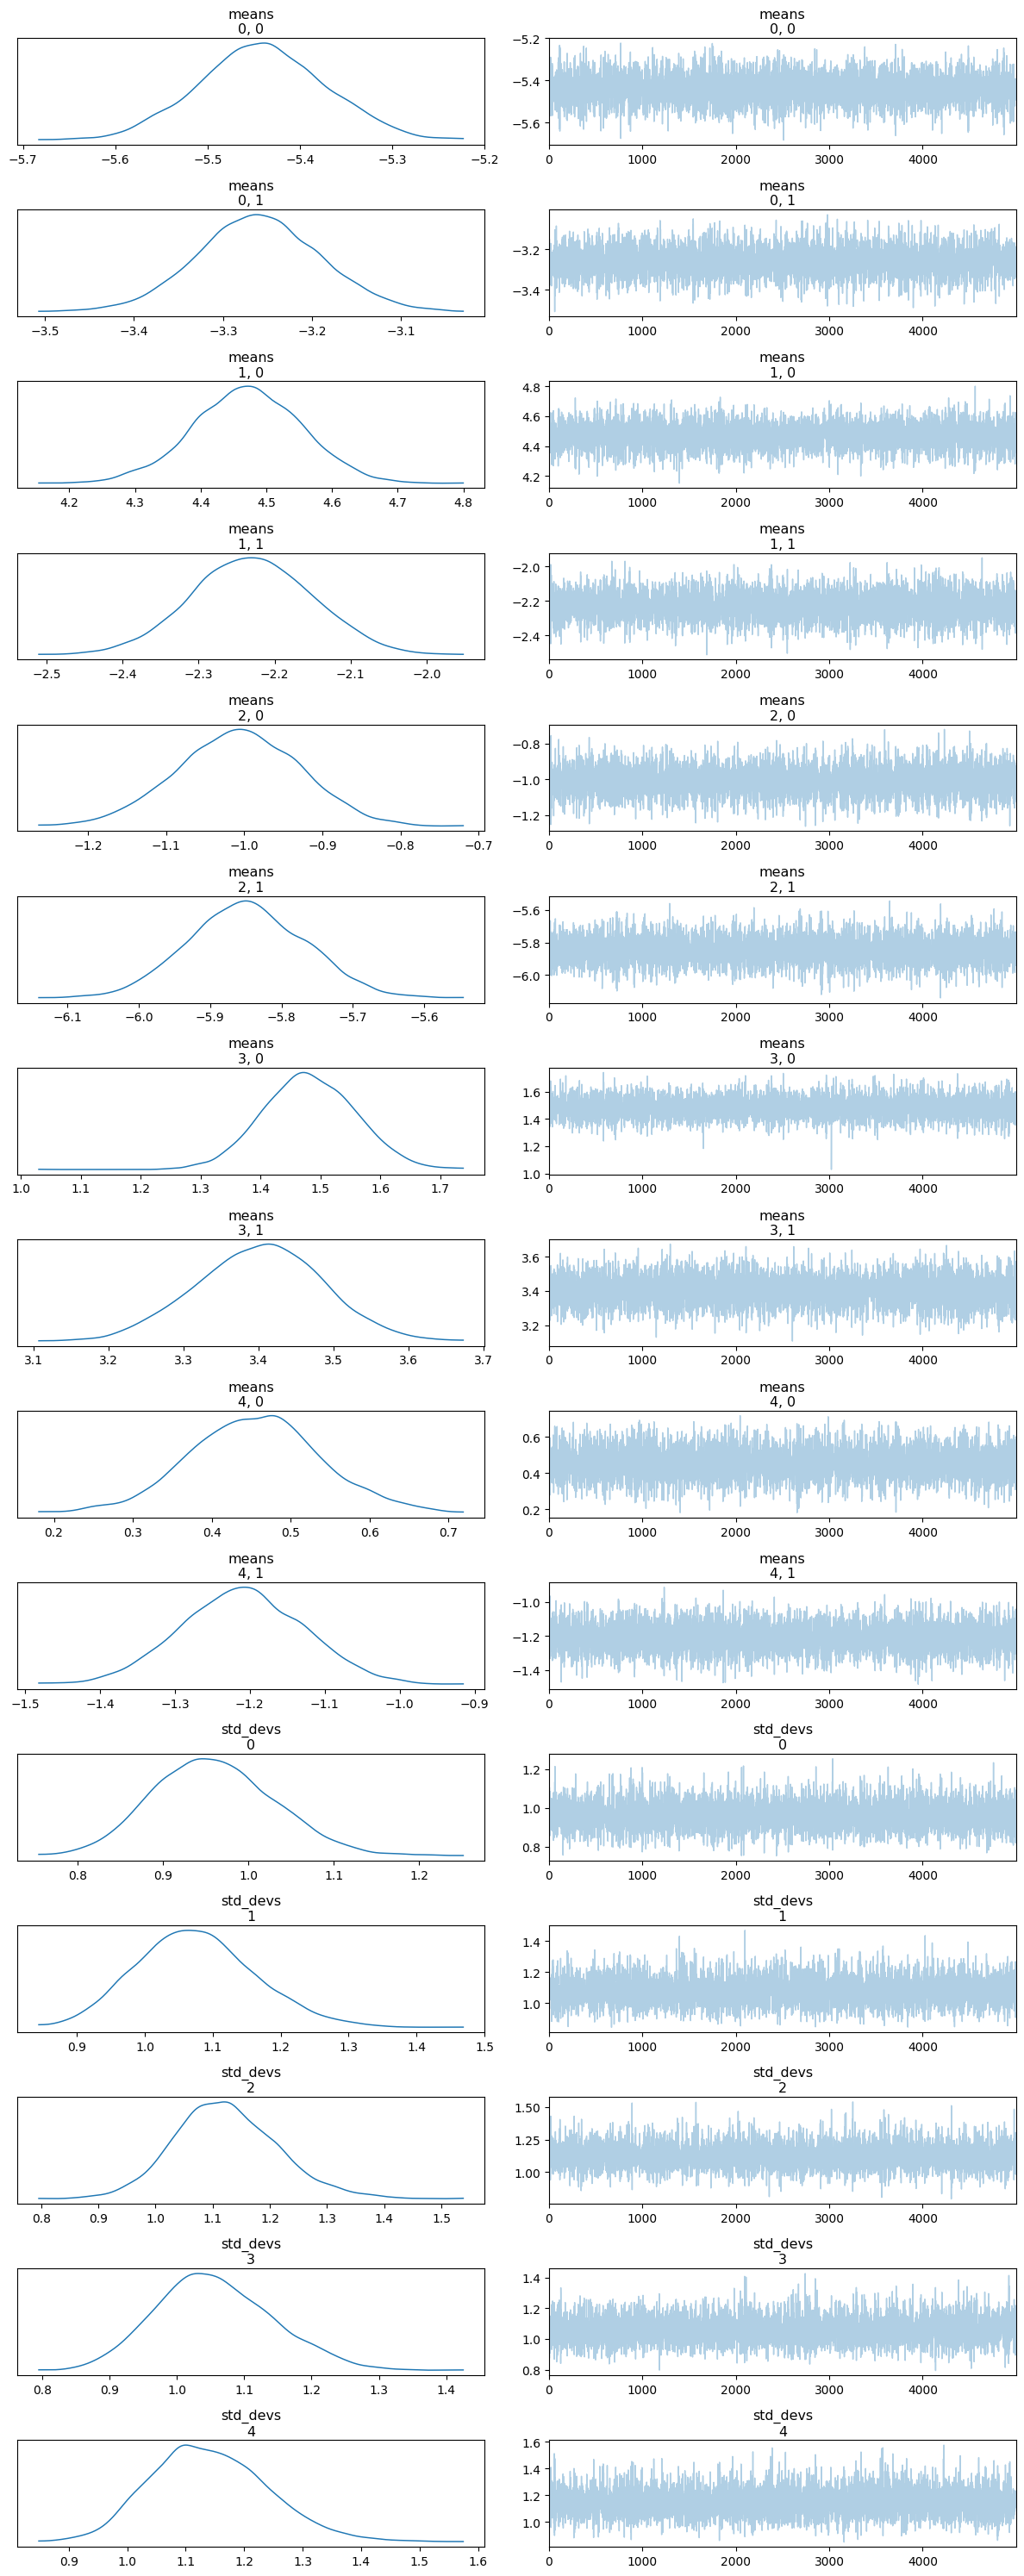

In [ ]:
az.plot_trace(chains, var_names=["means", "std_devs"], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp

def plot_clusters(data, phi, means):
    # Get the cluster assignments
    cluster_assignments = jnp.argmax(phi, axis=1)

    # Number of clusters
    num_clusters = means.shape[0]

    # Create a list of colors for plotting
    #colors = plt.colormaps()
    colors=mcp.gen_color(cmap="winter",n=6)
    print(colors)

    # Scatter plot each data point with its assigned color
    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        plt.scatter(data[cluster_assignments == cluster, 0], data[cluster_assignments == cluster, 1], c=colors[cluster], label=f'Cluster {cluster}')

    # Plot the cluster means
    for cluster in range(num_clusters):
        plt.scatter(means[cluster, 0], means[cluster, 1], marker='x', color='red', s=100, label=f'Mean Cluster {cluster}')

    plt.legend()
    plt.title('Cluster Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()